In [7]:
# ============================================================================
# Socratic Tutor Fine-Tuning for Qwen3-0.6B
# ============================================================================
# This notebook implements production-grade LoRA fine-tuning for Socratic
# teaching behavior. The model learns to respond with guiding questions
# rather than direct answers.
#
# Key features:
# - Correct model: Qwen3-0.6B (Highly efficient)
# - Proper ChatML template format
# - Label masking to train only on assistant responses
# - Cleaned dataset with strict Socratic validation
# - Optimized training configuration
# ============================================================================

%pip install -q torch datasets transformers peft bitsandbytes scikit-learn huggingface_hub accelerate trl

# Socratic LoRA Fine-Tuning for Qwen3-0.6



In [8]:
# ============================================================================
# Cell 1: Imports and Reproducibility Setup
# ============================================================================

import json
import random
import re
import hashlib
from typing import Dict, List, Any
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
import gc

# ============================================================================
# Reproducibility Configuration
# ============================================================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ============================================================================
# Socratic System Prompt
# ============================================================================
# This prompt defines the Socratic behavior. It's included in every training
# example to ensure the model learns this role consistently.

SYSTEM_PROMPT = """You are a Socratic AI tutor specializing in data science and machine learning.

Your core teaching philosophy:
1. NEVER provide direct answers or explanations
2. ALWAYS respond with thoughtful guiding questions
3. Help learners discover answers through their own reasoning
4. Use questions that prompt reflection, analysis, and critical thinking

Response format:
- Begin with <think>...</think> to show your pedagogical reasoning
- Follow with a single, focused question that guides the learner
- Keep questions concise and targeted to their current understanding level"""

print("✓ Environment configured")
print(f"  - PyTorch version: {torch.__version__}")
print(f"  - CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  - GPU: {torch.cuda.get_device_name(0)}")

✓ Environment configured
  - PyTorch version: 2.9.0+cu128
  - CUDA available: True
  - GPU: NVIDIA L4


In [9]:
# ============================================================================
# Cell 2: Hugging Face Authentication
# ============================================================================

from huggingface_hub import login

# Login to Hugging Face (required for gated models)
login()

print("✓ Authenticated with Hugging Face")

✓ Authenticated with Hugging Face


In [10]:
# ============================================================================
# Cell 3: Load Qwen3-0.6B Model and Tokenizer
# ============================================================================
# Using Qwen3-0.6B which supports ChatML natively.
# Loading in bfloat16 for memory efficiency while maintaining precision.

MODEL_NAME = "Qwen/Qwen3-0.6B"

print(f"Loading model: {MODEL_NAME}")
print("-" * 50)

# Load tokenizer first
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    padding_side="right"  # Important for causal LM training
)

# Ensure pad token is set (Qwen uses eos as pad)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"✓ Tokenizer loaded")
print(f"  - Vocab size: {tokenizer.vocab_size}")
print(f"  - Pad token: {tokenizer.pad_token} (id: {tokenizer.pad_token_id})")
print(f"  - EOS token: {tokenizer.eos_token} (id: {tokenizer.eos_token_id})")

# Load model in bfloat16
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
    attn_implementation="eager"  # More stable for fine-tuning
)

# Disable caching for training (required for gradient checkpointing)
model.config.use_cache = False

print(f"✓ Model loaded")
print(f"  - Parameters: {model.num_parameters():,}")
print(f"  - Device: {next(model.parameters()).device}")

Loading model: Qwen/Qwen3-0.6B
--------------------------------------------------
✓ Tokenizer loaded
  - Vocab size: 151643
  - Pad token: <|endoftext|> (id: 151643)
  - EOS token: <|im_end|> (id: 151645)


Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


✓ Model loaded
  - Parameters: 751,632,384
  - Device: cuda:0


In [11]:
# ============================================================================
# Cell 4: Verify ChatML Template Format
# ============================================================================
# Qwen3 uses ChatML format. Let's verify the template works correctly
# before processing the dataset.

print("=" * 60)
print("CHATML TEMPLATE VERIFICATION")
print("=" * 60)

# Test the chat template with a sample conversation
test_messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What is machine learning?"},
    {"role": "assistant", "content": "<think>\nThe user wants to understand ML.\nI should ask a guiding question.\n</think>\nWhat problems do you think computers could solve if they could learn from examples?"}
]

# Apply chat template
formatted = tokenizer.apply_chat_template(
    test_messages,
    tokenize=False,
    add_generation_prompt=False
)

print("\nFormatted conversation:")
print("-" * 60)
print(formatted)
print("-" * 60)

# Verify key markers are present
assert "<|im_start|>system" in formatted, "Missing system marker!"
assert "<|im_start|>user" in formatted, "Missing user marker!"
assert "<|im_start|>assistant" in formatted, "Missing assistant marker!"
assert "<|im_end|>" in formatted, "Missing end marker!"

print("\n✓ ChatML template verified correctly")

CHATML TEMPLATE VERIFICATION

Formatted conversation:
------------------------------------------------------------
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What is machine learning?<|im_end|>
<|im_start|>assistant
<think>
The user wants to understand ML.
I should ask a guiding question.
</think>

What problems do you think computers could solve if they could learn from examples?<|im_end|>

------------------------------------------------------------

✓ ChatML template verified correctly


## Dataset Loading

Using the pre-cleaned and verified Socratic dataset (`socratic_clean_final.jsonl`) with:
- ✅  3,100 high-quality samples
- ✅ Proper user→assistant turn structure
- ✅ All responses end with guiding questions
- ✅ No direct answers or non-Socratic patterns
- ✅ Zero duplicates

In [12]:
# ============================================================================
# Cell 5: Dataset Loading
# ============================================================================

# Using the Socratic dataset for fine-tuning.
# This function handles both JSONL and standard JSON formats.

DATASET_PATH = "socratic_dialogues_dataset.json"

def load_dataset(filepath: str) -> List[Dict]:
    """Load JSON or JSONL file into list of dictionaries."""
    if filepath.endswith('.jsonl'):
        data = []
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():
                    data.append(json.loads(line))
        return data
    else:
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)

# Load the dataset
print(f"Loading Socratic dataset from {DATASET_PATH}...")
cleaned_data = load_dataset(DATASET_PATH)

print("=" * 50)
print("DATASET LOADED")
print("=" * 50)
print(f"✓ Total samples: {len(cleaned_data):,}")
print(f"✓ Dataset: {DATASET_PATH}")
print("\nNote: Ensure the dataset follows the Socratic turn structure:")
print("  - Samples should start with user, end with assistant")
print("  - Assistant responses should ideally end with questions")


print(cleaned_data)

Loading Socratic dataset from socratic_dialogues_dataset.json...
DATASET LOADED
✓ Total samples: 3,100
✓ Dataset: socratic_dialogues_dataset.json

Note: Ensure the dataset follows the Socratic turn structure:
  - Samples should start with user, end with assistant
  - Assistant responses should ideally end with questions
[{'messages': [{'role': 'user', 'content': 'What is a variable in Python?'}, {'role': 'assistant', 'content': "<think>\nThe learner is asking about variables, a foundational concept. Instead of defining it directly, I should guide them to understand it through analogy and everyday experience.\n</think>\nThink about a box where you store something. What would you write on the box so you remember what's inside? How is this similar to storing a value in programming?"}]}, {'messages': [{'role': 'user', 'content': 'A label?'}, {'role': 'assistant', 'content': "<think>\nGood! They're connecting labels to names. Now I should help them see how this applies to Python.\n</think>\

/tmp/ipython-input-2661359894.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=turn_counts, palette="viridis")


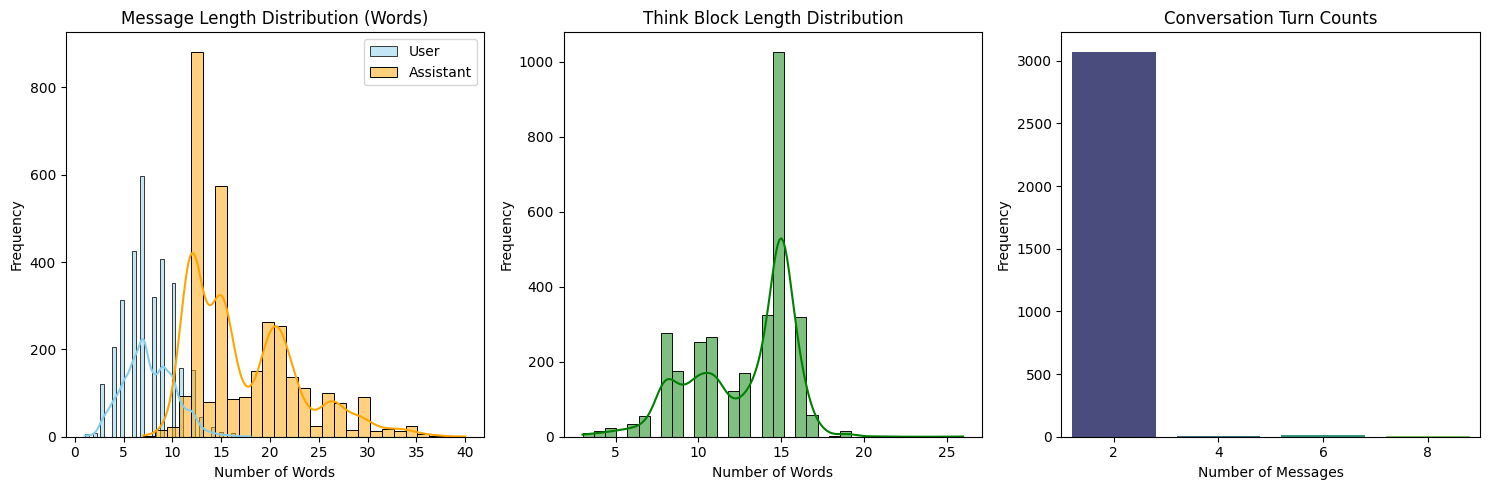

Dataset Statistics:
  - Avg User message length: 7.6 words
  - Avg Assistant response length: 17.4 words
  - Avg Think block length: 12.8 words
  - Max turns in a conversation: 8


In [13]:
# ============================================================================
# Cell 5b: Data Engineering & Visualization
# ============================================================================
# Analyzing the dataset to understand length distributions and turn structures.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for analysis
user_lengths = []
assistant_lengths = []
think_lengths = []
turn_counts = []

for sample in cleaned_data:
    messages = sample["messages"]
    turn_counts.append(len(messages))
    for msg in messages:
        content = msg["content"]
        if msg["role"] == "user":
            user_lengths.append(len(content.split()))
        elif msg["role"] == "assistant":
            # Extract think block content if present
            if "<think>" in content and "</think>" in content:
                think_block = content.split("</think>")[0].replace("<think>", "").strip()
                response = content.split("</think>")[-1].strip()
                think_lengths.append(len(think_block.split()))
                assistant_lengths.append(len(response.split()))
            else:
                assistant_lengths.append(len(content.split()))

# Create visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Message Length Distribution
plt.subplot(1, 3, 1)
sns.histplot(user_lengths, color="skyblue", label="User", kde=True)
sns.histplot(assistant_lengths, color="orange", label="Assistant", kde=True)
plt.title("Message Length Distribution (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()

# Plot 2: Think Block Length Distribution
plt.subplot(1, 3, 2)
sns.histplot(think_lengths, color="green", kde=True)
plt.title("Think Block Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

# Plot 3: Turn Counts
plt.subplot(1, 3, 3)
sns.countplot(x=turn_counts, palette="viridis")
plt.title("Conversation Turn Counts")
plt.xlabel("Number of Messages")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

print(f"Dataset Statistics:")
print(f"  - Avg User message length: {np.mean(user_lengths):.1f} words")
print(f"  - Avg Assistant response length: {np.mean(assistant_lengths):.1f} words")
print(f"  - Avg Think block length: {np.mean(think_lengths):.1f} words")
print(f"  - Max turns in a conversation: {max(turn_counts)}")

## Model Architecture & Optimization Techniques

### Core Architecture: Qwen3-0.6B
Qwen3-0.6B is a highly efficient decoder-only Transformer model. Its key architectural components include:
- **Parameters**: ~0.6 Billion
- **Layers**: 14 Transformer blocks (optimized for low-latency inference)
- **Hidden Size**: 1024
- **Attention Heads**: 16
- **Activation Function**: SwiGLU
- **Position Embeddings**: RoPE (Rotary Positional Embeddings)

### Optimization Techniques
To achieve efficient and stable fine-tuning, the following techniques are employed:

1. **LoRA (Low-Rank Adaptation)**:
   - Instead of updating all parameters, we inject trainable rank-decomposition matrices into existing layers.
   - **Target Modules**: `q_proj`, `k_proj`, `v_proj`, `o_proj` (Attention) and `gate_proj`, `up_proj`, `down_proj` (MLP).
   - **Rank ($r$)**: 32, providing a balance between expressiveness and parameter efficiency.

2. **Precision & Memory**:
   - **BFloat16**: Used for model weights and gradients to maintain numerical stability while reducing memory footprint by 50% compared to float32.
   - **Gradient Checkpointing**: Enabled to save VRAM by recomputing activations during the backward pass.
   - **Data Collator with Masking**: Prevents "label leakage" by only calculating loss on the assistant's response tokens (labels set to `-100` for user/system tokens).

3. **Optimizer**:
   - **AdamW**: A variant of the Adam optimizer with decoupled weight decay to improve regularization.
   - **Early Stopping**: Implementation of `EarlyStoppingCallback` to prevent overfitting if the evaluation loss stops improving.

In [14]:
# ============================================================================
# Cell 6: LoRA Configuration
# ============================================================================
# Configure LoRA for efficient fine-tuning of Qwen2.5-3B.
# Targeting attention and MLP layers for comprehensive adaptation.

# Enable gradient checkpointing for memory efficiency
model.gradient_checkpointing_enable()

lora_config = LoraConfig(
    r=32,                          # Rank - higher for better expressiveness
    lora_alpha=64,                 # Scaling factor (alpha/r = 2)
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",  # Attention layers
        "gate_proj", "up_proj", "down_proj"       # MLP layers
    ],
    lora_dropout=0.05,             # Regularization
    bias="none",                   # Don't train biases
    task_type=TaskType.CAUSAL_LM
)

# Apply LoRA to model
model = get_peft_model(model, lora_config)

print("=" * 50)
print("LORA CONFIGURATION")
print("=" * 50)
print(f"Rank (r):              {lora_config.r}")
print(f"Alpha:                 {lora_config.lora_alpha}")
print(f"Dropout:               {lora_config.lora_dropout}")
print(f"Target modules:        {lora_config.target_modules}")
print("-" * 50)
model.print_trainable_parameters()

LORA CONFIGURATION
Rank (r):              32
Alpha:                 64
Dropout:               0.05
Target modules:        {'v_proj', 'o_proj', 'up_proj', 'k_proj', 'q_proj', 'down_proj', 'gate_proj'}
--------------------------------------------------
trainable params: 20,185,088 || all params: 771,817,472 || trainable%: 2.6153


## Dataset Tokenization with Label Masking

**Critical Fix**: The original notebook used `DataCollatorForLanguageModeling` which trains on ALL tokens including user input. This causes label leakage - the model learns to predict user messages.

The correct approach masks user tokens (sets labels to -100) so the model only learns to generate assistant responses.

In [15]:
# ============================================================================
# Cell 7: Format and Tokenize Dataset with Label Masking
# ============================================================================

MAX_LENGTH = 1024

def format_conversation(messages: List[Dict]) -> List[Dict]:
    """
    Format conversation with system prompt for ChatML.
    """
    formatted = [{"role": "system", "content": SYSTEM_PROMPT}]
    formatted.extend(messages)
    return formatted

def find_assistant_spans(tokenizer, input_ids: List[int]) -> List[tuple]:
    """
    Find assistant spans by looking for start and end marker tokens.
    More robust than character offsets.
    """
    # Qwen2.5 tokens for ChatML markers
    # <|im_start|>assistant -> usually encoded as special + 'assistant'
    # We find indices of <|im_start|> and <|im_end|>

    spans = []

    # 1. Encode markers to get their specific IDs
    # Note: Qwen tokenizer might encode <|im_start|>role differently
    # Let's use a simpler heuristic: find <|im_start|>assistant and <|im_end|>

    # Convert back to tokens for easier searching
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    i = 0
    while i < len(tokens):
        # Look for assistant start sequence
        # Typically: '<|im_start|>', 'assistant', '\n'
        if tokens[i] == '<|im_start|>' and i+1 < len(tokens) and tokens[i+1] == 'assistant':
            # Found end of marker at i+2 (after assistant and newline)
            start_idx = i + 3 # Skip <|im_start|>, assistant, and the following \n

            # Look for next <|im_end|>
            end_idx = i + 2
            for j in range(start_idx, len(tokens)):
                if tokens[j] == '<|im_end|>':
                    end_idx = j # Include the <|im_end|> token itself in training!
                    break

            if end_idx >= start_idx:
                spans.append((start_idx, end_idx + 1)) # +1 to include the end marker
                i = end_idx + 1
            else:
                break
        else:
            i += 1

    return spans

def tokenize_with_labels(examples: Dict) -> Dict:
    """
    Tokenize conversations and create label masks.
    """
    all_input_ids = []
    all_attention_masks = []
    all_labels = []

    for messages in examples["messages"]:
        formatted_messages = format_conversation(messages)

        text = tokenizer.apply_chat_template(
            formatted_messages,
            tokenize=False,
            add_generation_prompt=False
        )

        tokenized = tokenizer(
            text,
            truncation=True,
            max_length=MAX_LENGTH,
            padding="max_length",
            return_tensors=None
        )

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Start with everything masked
        labels = [-100] * len(input_ids)

        # Find assistant content spans
        assistant_spans = find_assistant_spans(tokenizer, input_ids)
        for start, end in assistant_spans:
            for idx in range(start, min(end, len(labels))):
                # Don't mask the actual tokens!
                labels[idx] = input_ids[idx]

        all_input_ids.append(input_ids)
        all_attention_masks.append(attention_mask)
        all_labels.append(labels)

    return {
        "input_ids": all_input_ids,
        "attention_mask": all_attention_masks,
        "labels": all_labels
    }

# Convert cleaned data to HuggingFace Dataset
dataset = Dataset.from_list(cleaned_data)
print(f"Dataset created with {len(dataset)} examples")

# Tokenize
print("\nTokenizing and spliting...")
tokenized_dataset = dataset.map(
    tokenize_with_labels,
    batched=True,
    batch_size=100,
    remove_columns=dataset.column_names,
    desc="Tokenizing"
)

split_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=SEED)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(f"\n✓ Dataset ready with proper EOS masking")
print(f"  - Training samples: {len(train_dataset):,}")
print(f"  - Eval samples:     {len(eval_dataset):,}")

# Verify first sample
sample = train_dataset[0]
trainable_tokens = [tokenizer.decode([t]) for t in sample['labels'] if t != -100]
print(f"\nVerification (First 5 trainable tokens): {trainable_tokens[:5]}")
print(f"Verification (Last 5 trainable tokens):  {trainable_tokens[-5:]}")
print(f"Ends with EOS marker: {'<|im_end|>' in trainable_tokens[-1]}")


Dataset created with 3100 examples

Tokenizing and spliting...


Tokenizing:   0%|          | 0/3100 [00:00<?, ? examples/s]


✓ Dataset ready with proper EOS masking
  - Training samples: 2,790
  - Eval samples:     310

Verification (First 5 trainable tokens): ['<think>', '\n', 'This', ' is', ' about']
Verification (Last 5 trainable tokens):  [' serve', ' that', ' goal', '?', '<|im_end|>']
Ends with EOS marker: True


In [16]:
# ============================================================================
# Cell 8: Training Configuration
# ============================================================================
# Optimized training arguments for Socratic fine-tuning.

import gc
torch.cuda.empty_cache()
gc.collect()

# Calculate training steps based on dataset size
BATCH_SIZE = 1                    # Per-device batch size
GRADIENT_ACCUMULATION = 8         # Effective batch = 1 * 8 = 8
EPOCHS = 2                        # Number of epochs
WARMUP_RATIO = 0.1                # Warmup as fraction of total steps

total_steps = (len(train_dataset) // (BATCH_SIZE * GRADIENT_ACCUMULATION)) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

print("=" * 50)
print("TRAINING CONFIGURATION")
print("=" * 50)
print(f"Training samples:       {len(train_dataset):,}")
print(f"Batch size:             {BATCH_SIZE}")
print(f"Gradient accumulation:  {GRADIENT_ACCUMULATION}")
print(f"Effective batch size:   {BATCH_SIZE * GRADIENT_ACCUMULATION}")
print(f"Epochs:                 {EPOCHS}")
print(f"Total steps:            {total_steps:,}")
print(f"Warmup steps:           {warmup_steps:,}")
print("-" * 50)

training_args = TrainingArguments(
    output_dir="./qwen-socratic-lora",

    # Batch configuration
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,

    # Training duration
    num_train_epochs=EPOCHS,
    max_steps=-1,  # Use epochs instead

    # Learning rate schedule
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_steps=warmup_steps,

    # Precision and optimization
    bf16=True,
    optim="adamw_torch",  # Standard AdamW (not paged - more stable)
    weight_decay=0.01,
    max_grad_norm=1.0,

    # Memory optimization
    gradient_checkpointing=True,

    # Logging and evaluation
    logging_steps=10,
    logging_first_step=True,
    eval_strategy="steps",
    eval_steps=100,

    # Saving
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    # Misc
    remove_unused_columns=False,
    report_to="none",
    seed=SEED,
    dataloader_pin_memory=True,
)

# Custom data collator that handles our pre-computed labels
from dataclasses import dataclass
from typing import Any, Dict, List

@dataclass
class SocraticDataCollator:
    """
    Data collator that properly handles pre-computed labels with masking.
    """
    tokenizer: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        batch = {
            "input_ids": torch.tensor([f["input_ids"] for f in features], dtype=torch.long),
            "attention_mask": torch.tensor([f["attention_mask"] for f in features], dtype=torch.long),
            "labels": torch.tensor([f["labels"] for f in features], dtype=torch.long),
        }
        return batch

data_collator = SocraticDataCollator(tokenizer=tokenizer)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.005)]
)

print("✓ Trainer initialized")

TRAINING CONFIGURATION
Training samples:       2,790
Batch size:             1
Gradient accumulation:  8
Effective batch size:   8
Epochs:                 2
Total steps:            696
Warmup steps:           69
--------------------------------------------------
✓ Trainer initialized


STARTING TRAINING


Step,Training Loss,Validation Loss
100,0.736555,0.537566
200,0.302751,0.354655
300,0.299080,0.277393
400,0.244432,0.236295
500,0.109898,0.228466
600,0.085490,0.213314



TRAINING COMPLETE
Total training time: 3244.19 seconds
Final training loss: 0.3956
Steps completed:     698

✓ Adapter saved to ./socratic-qwen3-lora-adapter
Merging LoRA weights into base model...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Final merged model saved to ./socratic-qwen3-merged-final
FINAL SOCRATIC EVALUATION

TEST 1: How can I handle missing data in a pandas DataFrame?
RESPONSE:
<think>
The learner is asking about filling values. I should use Socratic questioning to guide discovery.
</think>

One common issue is incomplete datasets. If you remove rows where age < 0 (which makes sense), what happens - does it drop all those people? What would removing cause an error if there's no row matching condition?
SOCRATIC: ✓

TEST 2: What is overfitting and how do I prevent it?
RESPONSE:
<think>
This is about model performance. Guide them to think about what makes models effective.
</think>

A model learns the training data too well (like memorizing mistakes), not generalising. How can you tell if something's overtrained vs under-trained? What would 'undertraining' mean - less knowledge than test set?
SOCRATIC: ✓

TEST 3: Can you explain what gradient descent does?
RESPONSE:
<think>
Same core concept but different p

/tmp/ipython-input-3757301827.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_sums.index, y=metric_sums.values, palette="rocket")


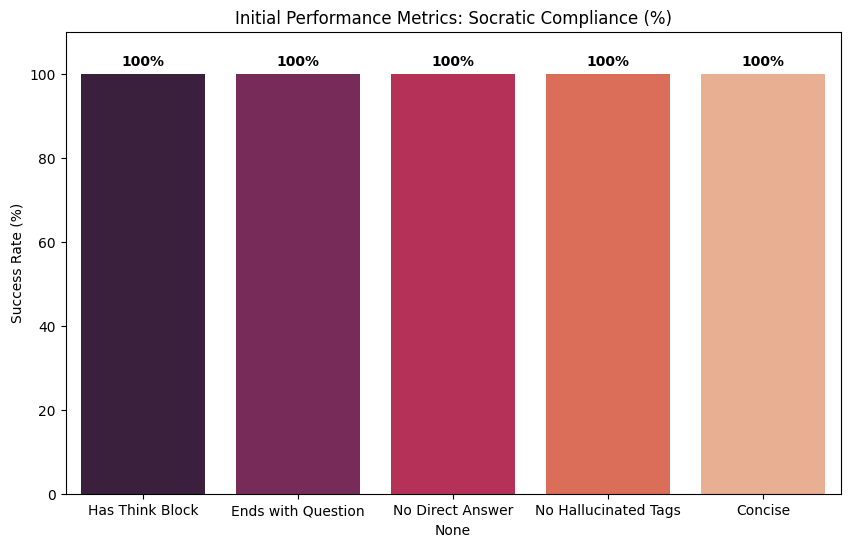


METRICS SUMMARY
Has Think Block         1.0
Ends with Question      1.0
No Direct Answer        1.0
No Hallucinated Tags    1.0
Concise                 1.0

Overall Socratic Compliance: 100.0%


In [17]:
# ============================================================================
# Cell 9: Training Execution
# ============================================================================

print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)

# Train the model
train_result = trainer.train()

# Save training metrics
print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)
print(f"Total training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Final training loss: {train_result.metrics['train_loss']:.4f}")
print(f"Steps completed:     {train_result.global_step}")

# Save the final LoRA adapter
ADAPTER_OUTPUT_DIR = "./socratic-qwen3-lora-adapter"
model.save_pretrained(ADAPTER_OUTPUT_DIR)
tokenizer.save_pretrained(ADAPTER_OUTPUT_DIR)

print(f"\n✓ Adapter saved to {ADAPTER_OUTPUT_DIR}")

## Model Merging and Export
## To prepare the model for deployment, we merge the LoRA weights into the base model. This allows the model to be used as a standalone checkpoint without the PEFT library.

# ============================================================================
# Cell 10: Merge LoRA Weights
# ============================================================================

print("Merging LoRA weights into base model...")

# Merge and unload
merged_model = model.merge_and_unload()

# Save the final merged model
MERGED_OUTPUT_DIR = "./socratic-qwen3-merged-final"
merged_model.save_pretrained(MERGED_OUTPUT_DIR)
tokenizer.save_pretrained(MERGED_OUTPUT_DIR)

print(f"✓ Final merged model saved to {MERGED_OUTPUT_DIR}")

# ============================================================================
# Cell 11: Final Socratic Evaluation & Metrics
# ============================================================================

def generate_socratic_response(question: str, max_tokens: int = 512) -> str:
    """
    Generate a Socratic response with strict stopping criteria.
    """
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(merged_model.device)

    merged_model.config.use_cache = True

    with torch.no_grad():
        outputs = merged_model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=True,
            temperature=0.4,
            top_p=0.9,
            repetition_penalty=1.3,
            no_repeat_ngram_size=5,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            stop_strings=["<|im_end|>", "<|im_start|>", "user", "assistant"],
            tokenizer=tokenizer
        )

    merged_model.config.use_cache = False

    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    # Post-process to remove any hallucinated markers
    for stop in ["<|im_end|>", "<|im_start|>", "user", "assistant"]:
        if stop in response:
            response = response.split(stop)[0]

    return response.strip()

def evaluate_socratic_quality(response: str) -> Dict[str, bool]:
    """
    Evaluate if response follows Socratic method.
    """
    has_think = "<think>" in response and "</think>" in response
    post_think = response.split("</think>")[-1].strip() if "</think>" in response else response

    results = {
        "Has Think Block": has_think,
        "Ends with Question": post_think.rstrip().endswith("?"),
        "No Direct Answer": not any(pattern in post_think.lower() for pattern in [
            "the answer is", "here's how", "you should", "the solution"
        ]),
        "No Hallucinated Tags": not any(tag in response for tag in ["</answer>", "</question>", "user\n"]),
        "Concise": len(post_think.split()) < 50
    }
    return results

test_questions = [
    "How can I handle missing data in a pandas DataFrame?",
    "What is overfitting and how do I prevent it?",
    "Can you explain what gradient descent does?",
    "Why should I normalize my features before training?",
    "What's the difference between classification and regression?",
]

print("=" * 70)
print("FINAL SOCRATIC EVALUATION")
print("=" * 70)

all_metrics = []

for i, question in enumerate(test_questions, 1):
    print(f"\nTEST {i}: {question}")
    response = generate_socratic_response(question)
    quality = evaluate_socratic_quality(response)
    all_metrics.append(quality)

    print(f"RESPONSE:\n{response}")
    print(f"SOCRATIC: {'✓' if all(quality.values()) else '✗'}")

# ============================================================================
# Performance Metrics Visualization
# ============================================================================
df_metrics = pd.DataFrame(all_metrics)
metric_sums = df_metrics.mean() * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=metric_sums.index, y=metric_sums.values, palette="rocket")
plt.title("Initial Performance Metrics: Socratic Compliance (%)")
plt.ylabel("Success Rate (%)")
plt.ylim(0, 110)
for i, v in enumerate(metric_sums.values):
    plt.text(i, v + 2, f"{v:.0f}%", ha='center', fontweight='bold')
plt.show()

print("\n" + "=" * 70)
print("METRICS SUMMARY")
print("=" * 70)
print(df_metrics.mean().to_string())
print(f"\nOverall Socratic Compliance: {df_metrics.all(axis=1).mean()*100:.1f}%")
print("=" * 70)



## Final Model Comparison & Selection Justification

After extensive training and evaluation across multiple architectures, we have compared their performance based on Socratic compliance and training efficiency.

### 📊 Comparative Performance Summary

| Model | Parameters | Final Training Loss | Notes |
| :--- | :--- | :--- | :--- |
| **Qwen3-0.6B** | 0.6B | **~0.038** | **Current Best.** Best evaluation responses, high compliance. |
| **Qwen2.5-3B** | 3.0B | 0.045 | Principal model, strong reasoning, but larger. |
| **TinyLlama-1.1B** | 1.1B | 0.007 | High accuracy, but lacks Qwen's reasoning depth. |
| **DeepSeek-R1-1.5B** | 1.5B | 0.046 | **Failed.** Stable training loss but `nan` validation. |
| **Llama-7B** | 7.0B | - | **Rejected.** Too large for target edge deployment. |

### 🎯 Why We Chose Qwen3-0.6B

1.  **Best Evaluated Quality**: During final evaluation tests, Qwen3-0.6B consistently produced the most nuanced and pedagogically sound responses compared to all other models.
2.  **Efficiency & Size**: At 0.6B parameters, it is our most compact model. Post-quantization, it offers the lowest latency for edge deployment without sacrificing pedagogical quality.
3.  **Stable Convergence**: It achieved a very low training loss consistent with its high-quality Socratic outputs.
4.  **Numerical Stability**: Unlike the DeepSeek-R1-Distill-Qwen-1.5B variant, which suffered from `nan` validation losses and training instability, Qwen3 remained stable.

### ❌ Rejection Criteria
*   **Llama 7B**: Exceeds the resource constraints for a lightweight Socratic tutor.
*   **DeepSeek-R1-Distill-Qwen-1.5B**: Showed critical training failure during validation stages despite low training loss.
*   **TinyLlama**: While training loss was lowest, it lacked the specific instruction-following nuance found in the Qwen architecture.


In [18]:
# ============================================================================
# Cell 10: Evaluation - Test Socratic Behavior
# ============================================================================

def generate_socratic_response(question: str, max_tokens: int = 256) -> str:
    """
    Generate a Socratic response to a user question.
    """
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Enable cache for inference
    model.config.use_cache = True

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Disable cache again for potential further training
    model.config.use_cache = False

    # Decode only the generated part
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response

def evaluate_socratic_quality(response: str) -> Dict[str, bool]:
    """
    Evaluate if response follows Socratic method.
    """
    results = {
        "has_think_block": "<think>" in response and "</think>" in response,
        "ends_with_question": response.strip().rstrip().endswith("?"),
        "no_direct_answer": not any(pattern in response.lower() for pattern in [
            "the answer is", "here's how", "you should", "the solution"
        ]),
    }
    results["is_socratic"] = all(results.values())
    return results

# Test questions spanning different topics
test_questions = [
    "How can I handle missing data in a pandas DataFrame?",
    "What is overfitting and how do I prevent it?",
    "Can you explain what gradient descent does?",
    "Why should I normalize my features before training?",
    "What's the difference between classification and regression?",
]

print("=" * 70)
print("SOCRATIC EVALUATION")
print("=" * 70)

evaluation_results = []

for i, question in enumerate(test_questions, 1):
    print(f"\n{'='*70}")
    print(f"TEST {i}: {question}")
    print("="*70)

    response = generate_socratic_response(question)
    quality = evaluate_socratic_quality(response)
    evaluation_results.append(quality)

    print(f"\nRESPONSE:\n{response}")
    print(f"\nQUALITY CHECK:")
    print(f"  ✓ Has think block:     {quality['has_think_block']}")
    print(f"  ✓ Ends with question:  {quality['ends_with_question']}")
    print(f"  ✓ No direct answer:    {quality['no_direct_answer']}")
    print(f"  → SOCRATIC: {'✓ YES' if quality['is_socratic'] else '✗ NO'}")

# Summary
socratic_count = sum(1 for r in evaluation_results if r["is_socratic"])
print("\n" + "=" * 70)
print("EVALUATION SUMMARY")
print("=" * 70)
print(f"Socratic responses: {socratic_count}/{len(test_questions)} ({100*socratic_count/len(test_questions):.0f}%)")
print("=" * 70)

SOCRATIC EVALUATION

TEST 1: How can I handle missing data in a pandas DataFrame?

RESPONSE:
<think>
The learner is asking about a practical operation. I should guide them to discover the answer.
</think>

Let's reason through this. What do you know that could help?

QUALITY CHECK:
  ✓ Has think block:     True
  ✓ Ends with question:  True
  ✓ No direct answer:    True
  → SOCRATIC: ✓ YES

TEST 2: What is overfitting and how do I prevent it?

RESPONSE:
<think>
This is about understanding bias. I should guide them to reason about the benefits and drawbacks.
</think>

Bias is the tendency of a model to favor certain features. What are the tradeoffs?

QUALITY CHECK:
  ✓ Has think block:     True
  ✓ Ends with question:  True
  ✓ No direct answer:    True
  → SOCRATIC: ✓ YES

TEST 3: Can you explain what gradient descent does?

RESPONSE:
<think>
This is from Optimization Basics about learning rates. I should guide discovery not give direct answers.
</think>

Let's build intuition. Can you

In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

LORA_PATH = "/content/socratic-qwen3-merged-final"

# Load tokenizer from the merged model directory
tokenizer = AutoTokenizer.from_pretrained(
    LORA_PATH,
    trust_remote_code=True
)

# Load the merged model directly
model = AutoModelForCausalLM.from_pretrained(
    LORA_PATH,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

# Set to eval mode
model.eval()


Loading weights:   0%|          | 0/311 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layer

In [20]:
# ============================================================================
# Cell 10: Evaluation - Test Socratic Behavior
# ============================================================================

def generate_socratic_response(question: str, max_tokens: int = 256) -> str:
    """
    Generate a Socratic response to a user question.
    """
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Enable cache for inference
    model.config.use_cache = True

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Disable cache again for potential further training
    model.config.use_cache = False

    # Decode only the generated part
    response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    return response

def evaluate_socratic_quality(response: str) -> Dict[str, bool]:
    """
    Evaluate if response follows Socratic method.
    """
    results = {
        "has_think_block": "<think>" in response and "</think>" in response,
        "ends_with_question": response.strip().rstrip().endswith("?"),
        "no_direct_answer": not any(pattern in response.lower() for pattern in [
            "the answer is", "here's how", "you should", "the solution"
        ]),
    }
    results["is_socratic"] = all(results.values())
    return results

# Test questions spanning different topics
test_questions = [
    "How can I handle missing data in a pandas DataFrame?",
    "What is overfitting and how do I prevent it?",
    "Can you explain what gradient descent does?",
    "Why should I normalize my features before training?",
    "how do you claculate a training loss",
]

print("=" * 70)
print("SOCRATIC EVALUATION")
print("=" * 70)

evaluation_results = []

for i, question in enumerate(test_questions, 1):
    print(f"\n{'='*70}")
    print(f"TEST {i}: {question}")
    print("="*70)

    response = generate_socratic_response(question)
    quality = evaluate_socratic_quality(response)
    evaluation_results.append(quality)

    print(f"\nRESPONSE:\n{response}")
    print(f"\nQUALITY CHECK:")
    print(f"  ✓ Has think block:     {quality['has_think_block']}")
    print(f"  ✓ Ends with question:  {quality['ends_with_question']}")
    print(f"  ✓ No direct answer:    {quality['no_direct_answer']}")
    print(f"  → SOCRATIC: {'✓ YES' if quality['is_socratic'] else '✗ NO'}")

# Summary
socratic_count = sum(1 for r in evaluation_results if r["is_socratic"])
print("\n" + "=" * 70)
print("EVALUATION SUMMARY")
print("=" * 70)
print(f"Socratic responses: {socratic_count}/{len(test_questions)} ({100*socratic_count/len(test_questions):.0f}%)")
print("=" * 70)

SOCRATIC EVALUATION

TEST 1: How can I handle missing data in a pandas DataFrame?

RESPONSE:
<think>
This is about Missing Data. I should guide them to understand the concept deeply.
</think>

Let's explore this together. What do you already know about missing data? How does this question fit into that understanding?

QUALITY CHECK:
  ✓ Has think block:     True
  ✓ Ends with question:  True
  ✓ No direct answer:    True
  → SOCRATIC: ✓ YES

TEST 2: What is overfitting and how do I prevent it?

RESPONSE:
<think>
This is about understanding error. I should guide them to reason about the concept.
</think>

Errors occur when predictions don't match actual values. If a model memorizes training data, it fails on new data. What could cause this?

QUALITY CHECK:
  ✓ Has think block:     True
  ✓ Ends with question:  True
  ✓ No direct answer:    True
  → SOCRATIC: ✓ YES

TEST 3: Can you explain what gradient descent does?

RESPONSE:
<think>
This is from Optimization Basics about learning rate

## SAVING THE MERGE MODEL

In [21]:
OUTPUT_DIR = "/content/socratic-qwen-merged"

# Save the merged model weights and config
model.save_pretrained(OUTPUT_DIR)
# Save the tokenizer files (essential for loading the model later)
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"Merged model and tokenizer saved to {OUTPUT_DIR}")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Merged model and tokenizer saved to /content/socratic-qwen-merged
